In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2ad89ae9488>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [12]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2ad89adcbc8>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23')

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.datetime(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcpdata = session.query(measurement.date, measurement.prcp).\
    filter(func.strftime(measurement.date) >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcpframe = pd.DataFrame(prcpdata, columns=['date', 'prcp'])
prcpframe = prcpframe.sort_values(by=['date'])
prcpframe = prcpframe.set_index('date')
# Sort the dataframe by date
prcpframe







,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


In [15]:
print(year_ago)

2016-08-23 00:00:00


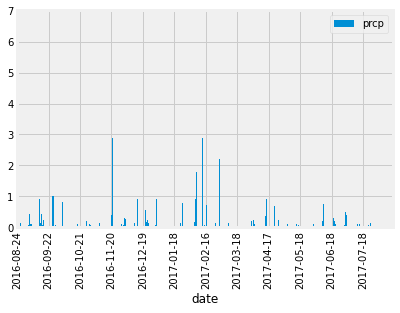

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpframe.plot.bar()
plt.locator_params(axis="x", nbins=12)
plt.show()

In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean = prcpframe.prcp.mean()
count = prcpframe.prcp.count()
std = prcpframe.prcp.std()
quartiles = prcpframe["prcp"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
print(mean)
print(count)
print(std)
print(lowerq)
print(upperq)
print(iqr)

0.17646153846153845
2015
0.46028836368132575
0.0
0.13
0.13


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
count = session.query(station.station).count()
count

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activestation = session.query(measurement.station, measurement.id).\
                    group_by(measurement.station).order_by(-measurement.id).all()
activestation

[('USC00516128', 16939),
 ('USC00511918', 14960),
 ('USC00519281', 12188),
 ('USC00519523', 9519),
 ('USC00518838', 9008),
 ('USC00517948', 7636),
 ('USC00514830', 5434),
 ('USC00513117', 2725),
 ('USC00519397', 1)]

In [20]:
most_active_station = (activestation[0])[0]
most_active_station

'USC00516128'

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Temperature isn't provided, I assume you mean precpitation?
sel = [measurement.station, func.avg(measurement.tobs), func.min(measurement.tobs), func.max(measurement.tobs)]
active_data = session.query(*sel).filter(measurement.station == most_active_station).order_by(measurement.tobs).all()
average = (active_data[0])[1]
low = (active_data[0])[2]
high = (active_data[0])[3]

print(average)
print(low)
print(high)


70.91500765696784
58.0
84.0


In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel2 = [measurement.station, measurement.date, measurement.tobs]
active_data_year = session.query(*sel2).filter(measurement.station == most_active_station).filter(func.strftime(measurement.date) >= dt.datetime(2016,8,23)).order_by(measurement.tobs).all()
tempframe = pd.DataFrame(active_data_year, columns=['station', 'date', 'tobs'])
tempframe = tempframe.sort_values(by='date')
tempframe


,station,date,tobs
213,USC00516128,2016-08-24,74.0
305,USC00516128,2016-08-25,77.0
214,USC00516128,2016-08-27,74.0
114,USC00516128,2016-08-28,71.0
326,USC00516128,2016-08-29,78.0
...,...,...,...
148,USC00516128,2017-08-19,71.0
335,USC00516128,2017-08-20,78.0
302,USC00516128,2017-08-21,76.0
303,USC00516128,2017-08-22,76.0


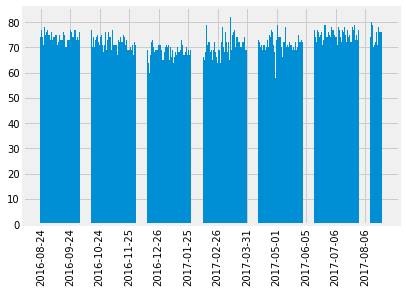

In [23]:
plt.bar(tempframe['date'], tempframe['tobs'])
plt.xticks(tempframe['date'], rotation='vertical')
plt.xticks(np.arange(0, len(tempframe['date'])+1, 30))
plt.show()

In [24]:
# Some code I used to test for the flask part
# pdata = session.query(measurement.date, measurement.prcp).\
#     filter(func.strftime(measurement.date) >= year_ago).filter(func.strftime(measurement.date) <= dt.datetime(2017,7,23)) .all()
# frame = pd.DataFrame(pdata, columns=['date', 'prcp'])
# frame

# Close session

In [25]:
# Close Session
session.close()